# XGBoost

In [2]:
# %load ../src/globals.py
INMET_API_BASE_URL = "https://apitempo.inmet.gov.br"

# Weather stations datasource directories
WS_INMET_DATA_DIR = "./data/ws/inmet/"
WS_ALERTARIO_DATA_DIR = "./data/ws/alertario/ws/"
GS_ALERTARIO_DATA_DIR = "./data/ws/alertario/rain_gauge_era5_fused/"

# WS_GOES_DATA_DIR = "atmoseer/data/ws/goes16"
GOES_DATA_DIR = "./data/goes16"

# Atmospheric sounding datasource directory
NWP_DATA_DIR = "./data/NWP/"

# Atmospheric sounding datasource directory
AS_DATA_DIR = "./data/as/"

#GOES16/DSI directory
DSI_DATA_DIR = "./data/goes16/DSI"

# GOES16/TPW directory
TPW_DATA_DIR = "./data/goes16/wsoi"

# Directory to store the train/val/test datasets for each weather station of interest
DATASETS_DIR = './data/datasets/'

# Directory to store the generated models and their corresponding reports
MODELS_DIR = './models/'

# see https://portal.inmet.gov.br/paginas/catalogoaut
INMET_WEATHER_STATION_IDS = (
    'A601', # Seropédica
    'A602', # Marambaia
    'A621', # Vila militar
    'A627', # Niteroi
    'A636', # Jacarepagua
    'A652'  # Forte de Copacabana
)

ALERTARIO_GAUGE_STATION_IDS = (
                         'anchieta', 
                         'av_brasil_mendanha', 
                         'bangu', 
                         'barrinha', 
                         'campo_grande', 
                         'cidade_de_deus', 
                         'copacabana', 
                         'grajau_jacarepagua', 
                         'grajau', 
                         'grande_meier', 
                         'grota_funda', 
                         'ilha_do_governador', 
                         'laranjeiras', 
                         'madureira', 
                         'penha', 
                         'piedade', 
                         'recreio', 
                         'rocinha',
                         'santa_teresa',
                         'saude', 
                         'sepetiba', 
                         'tanque', 
                         'tijuca_muda', 
                         'tijuca', 
                         'urca',
                         'alto_da_boa_vista', #**
                         'iraja', #**
                         'jardim_botanico', #**
                         'riocentro', #**
                         'santa_cruz', #**
                         'vidigal' #**
                         )

ALERTARIO_WEATHER_STATION_IDS = (
                         'guaratiba', #**
                         'sao_cristovao' #**
                         )

# hyper_params_dict_bc = {
#     "N_EPOCHS" : 3500,
#     "PATIENCE" : 1000,
#     "BATCH_SIZE" : 1024,
#     "WEIGHT_DECAY" : 0,
#     "LEARNING_RATE" : 0.0003,
#     "DROPOUT_RATE" : 0.5,
#     "SLIDING_WINDOW_SIZE" : 6
# }

# hyper_params_dict_oc = {
#     "N_EPOCHS" : 6000,
#     "PATIENCE" : 1000,
#     "BATCH_SIZE" : 1024,
#     "WEIGHT_DECAY" : 0,
#     "LEARNING_RATE" : 3e-6,
#     "DROPOUT_RATE" : 0.5,
#     "SLIDING_WINDOW_SIZE" : 6
# }


# Observed variables for INMET weather stations:
# ,DC_NOME,
# PRE_INS,
# TEM_SEN,
# VL_LATITUDE,
# PRE_MAX,UF,
# RAD_GLO,
# PTO_INS,
# TEM_MIN,
# VL_LONGITUDE,
# UMD_MIN,
# PTO_MAX,
# VEN_DIR,
# DT_MEDICAO,
# CHUVA,
# PRE_MIN,
# UMD_MAX,
# VEN_VEL,
# PTO_MIN,
# TEM_MAX,
# TEN_BAT,
# VEN_RAJ,
# TEM_CPU,
# TEM_INS,
# UMD_INS,
# CD_ESTACAO,
# HR_MEDICAO

In [6]:
# %load ../src/train/xgboost.py
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import classification_report

def _train_and_test_classifier(X_train, y_train, X_test, y_test):

    print(f"Shapes before reshaping: ", X_train.shape, X_test.shape)
    X_train = X_train.reshape(len(X_train), -1)
    X_test = X_test.reshape(len(X_test), -1)
    print(f"Shapes after reshaping: ", X_train.shape, X_test.shape)

    y_train[y_train>0] = 1
    y_test[y_test>0] = 1

    # Create a GradientBoostingClassifier object with default hyperparameters
    clf = GradientBoostingClassifier()

    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = clf.predict(X_test.reshape(len(X_test), -1))
    
    y_true = y_test
    y_true[y_true>0] = 1

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return cm, y_true, y_pred

def report_results(cm, y_true, y_pred, title = None):
    # Define the class labels
    class_names = ['Negative', 'Positive']

    # Create a heatmap using Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Add labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    if title is not None:
        plt.title('Confusion Matrix - ' + title)
    else:
        plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    # Build the classification report
    target_names = ['Negative', 'Positive']
    report = classification_report(y_true, y_pred, target_names=target_names)

    # Print the classification report
    print(report)

def train_and_test_classifier(pipeline_id):
    filename = f"../data/datasets/{pipeline_id}.pickle"
    print(f"Loading train/val/test datasets from {filename}.")
    file = open(filename, 'rb')
    (X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
    print(f"Shapes of train/val/test data matrices: {X_train.shape}/{X_val.shape}/{X_test.shape}")
    cm, y_true, y_pred = _train_and_test_classifier(X_train, y_train, X_test, y_test)
    report_results(cm, y_true, y_pred, pipeline_id)

In [10]:
pipeline_id = 'A602'
filename = f"../data/datasets/{pipeline_id}.pickle"
print(f"Loading train/val/test datasets from {filename}.")
file = open(filename, 'rb')
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)

Loading train/val/test datasets from ../data/datasets/A602.pickle.


In [12]:
y_train, y_val, y_test

(array([[0. ],
        [0. ],
        [0. ],
        ...,
        [2.2],
        [0. ],
        [0.6]]),
 array([[0.2],
        [0. ],
        [1.6],
        ...,
        [0. ],
        [0. ],
        [0. ]]),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]))

Loading train/val/test datasets from ../data/datasets/A602.pickle.
Shapes of train/val/test data matrices: (13651, 3, 8)/(3436, 3, 8)/(11447, 3, 8)
Shapes before reshaping:  (13651, 3, 8) (11447, 3, 8)
Shapes after reshaping:  (13651, 24) (11447, 24)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


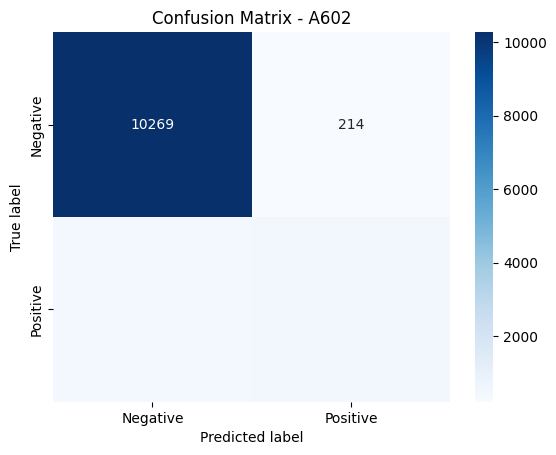

              precision    recall  f1-score   support

    Negative       0.96      0.98      0.97     10483
    Positive       0.70      0.53      0.61       964

    accuracy                           0.94     11447
   macro avg       0.83      0.75      0.79     11447
weighted avg       0.94      0.94      0.94     11447



In [9]:
station = 'A602'
train_and_test_classifier(station)
# train_and_test_classifier(station + '_DSI')

Loading train/val/test datasets from ../data/datasets/A601.pickle.
Shapes of train/val/test data matrices: (12821, 3, 8)/(3202, 3, 8)/(13094, 3, 8)
Shapes before reshaping:  (12821, 3, 8) (13094, 3, 8)
Shapes after reshaping:  (12821, 24) (13094, 24)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


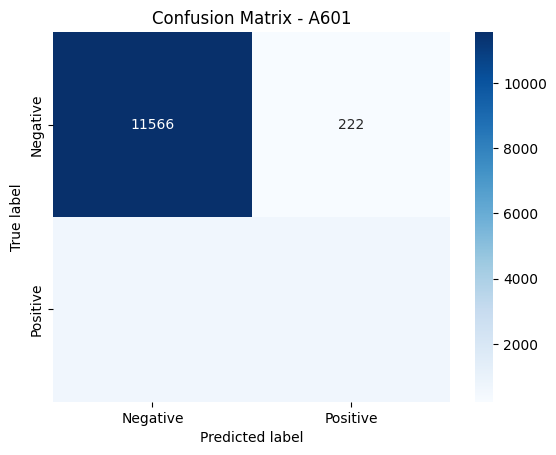

              precision    recall  f1-score   support

    Negative       0.95      0.98      0.96     11788
    Positive       0.74      0.50      0.60      1306

    accuracy                           0.93     13094
   macro avg       0.85      0.74      0.78     13094
weighted avg       0.93      0.93      0.93     13094

Loading train/val/test datasets from ../data/datasets/A601_DSI.pickle.
Shapes of train/val/test data matrices: (12693, 3, 13)/(3160, 3, 13)/(12971, 3, 13)
Shapes before reshaping:  (12693, 3, 13) (12971, 3, 13)
Shapes after reshaping:  (12693, 39) (12971, 39)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


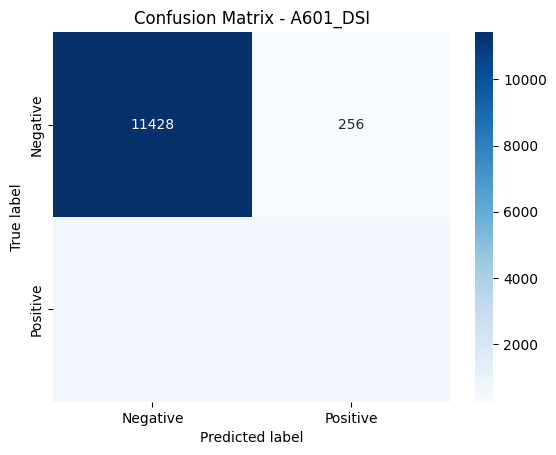

              precision    recall  f1-score   support

    Negative       0.95      0.98      0.96     11684
    Positive       0.72      0.50      0.59      1287

    accuracy                           0.93     12971
   macro avg       0.83      0.74      0.78     12971
weighted avg       0.92      0.93      0.93     12971



In [7]:
for station in INMET_WEATHER_STATION_IDS:
    train_and_test_classifier(station)
    train_and_test_classifier(station + '_DSI')